In [1]:
!pip install rdkit
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.0 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors, Descriptors

In [6]:
# Helper functions
def compute_descriptors(smiles_series):
    """Compute 3D inertia, TPSA, MR, and Gasteiger charge stats."""
    cols = ('inertia_sum','inertia_ratio','TPSA','MR','chg_mean','chg_std')
    records = []
    for smi in smiles_series:
        m = Chem.AddHs(Chem.MolFromSmiles(smi))
        if AllChem.EmbedMolecule(m, randomSeed=42) != 0:
            vals = [np.nan]*6
        else:
            AllChem.UFFOptimizeMolecule(m, confId=0)
            I1, I2, I3 = rdMolDescriptors.CalcPMI1(m), rdMolDescriptors.CalcPMI2(m), rdMolDescriptors.CalcPMI3(m)
            vals = [I1+I2+I3, I1/(I2+1e-6), rdMolDescriptors.CalcTPSA(m), Descriptors.MolMR(m)]
            AllChem.ComputeGasteigerCharges(m)
            ch = [float(a.GetProp('_GasteigerCharge')) for a in m.GetAtoms()]
            vals += [np.mean(ch), np.std(ch)]
        records.append(dict(zip(cols, vals)))
    return pd.DataFrame.from_records(records)

def evaluate_all(y_true, y_pred, target_names):
    """Compute RMSE, MAE and R² per target column."""
    records = []
    for i, name in enumerate(target_names):
        yt, yp = y_true[:, i], y_pred[:, i]
        records.append({
            "Target": name,
            "RMSE": np.sqrt(mean_squared_error(yt, yp)),
            "MAE": mean_absolute_error(yt, yp),
            "R2": r2_score(yt, yp)
        })
    return pd.DataFrame(records).set_index("Target")

In [7]:
# Data preprocessing
df = pd.read_csv('dataset_9May.csv')
smiles = df.pop('Molecule')
desc_df = compute_descriptors(smiles)
df = pd.concat([df, desc_df], axis=1)

targets = ['gap','mu','alpha','homo','lumo','r2','zpve','U0','U','H','G','Cv']
features = [c for c in df.columns if c not in targets + ['Molecule']]
X = df[features].fillna(0)
Y = df[targets].copy()

# ✅ IMPROVED: Proper log transformation with safety checks
log_targets = ['mu', 'r2']
for col in log_targets:
    # Add small constant to handle zeros/negatives, then apply log1p
    Y[col] = np.log1p(np.maximum(Y[col], 1e-8))

# Stratified split
atoms = [c for c in df.columns if len(c)==1 and c.isupper()]
size = df[atoms].sum(axis=1)
X_tr, X_te, Y_tr, Y_te = train_test_split(X, Y, test_size=0.2, random_state=42,
                                         stratify=pd.qcut(size, 5))

# Separate scaling for inputs and outputs
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_tr)
X_test_scaled = scaler_X.transform(X_te)
Y_train_scaled = scaler_Y.fit_transform(Y_tr)
Y_test_scaled = scaler_Y.transform(Y_te)

In [12]:
# ✅ IMPROVED: Enhanced model builder with learning rate tuning
def build_model(hp):
    model = tf.keras.Sequential()

    # First layer
    model.add(tf.keras.layers.Dense(
        hp.Int('units_1', 64, 512, step=64),
        activation='relu',
        input_dim=X_train_scaled.shape[1]
    ))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))

    # Optional second layer
    if hp.Boolean('second_layer'):
        model.add(tf.keras.layers.Dense(
            hp.Int('units_2', 32, 256, step=32),
            activation='relu'
        ))
        model.add(tf.keras.layers.Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))

    # Output layer
    model.add(tf.keras.layers.Dense(Y_train_scaled.shape[1]))

    # ✅ IMPROVED: Learning rate and batch size tuning
    optimizer_name = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    batch_size = hp.Int('batch_size', 32, 128, step=32)

    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [14]:
#✅ IMPROVED: Hyperparameter tuning with better configuration
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=30,  # Increased for better exploration
    executions_per_trial=2,  # Multiple runs for stability
    directory='nn_tuning',
    project_name='molecular_properties',
    overwrite=True
)

# Search with better callbacks
tuner.search(
    X_train_scaled, Y_train_scaled,
    epochs=100,
    validation_split=0.2,
    batch_size=64,  # Fixed batch size for search
    callbacks=[
        tf.keras.callbacks.EarlyStopping('val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau('val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ],
    verbose=0
)

# Get best model and retrain
best_hps = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.get_best_models(1)[0]

print("Best hyperparameters:")
for k, v in best_hps.values.items():
    print(f"  {k}: {v}")

Best hyperparameters:
  units_1: 320
  dropout_1: 0.30000000000000004
  second_layer: True
  optimizer: adam
  learning_rate: 0.0040018357220400124
  batch_size: 32
  units_2: 256
  dropout_2: 0.4


In [16]:
# Final training on full training data
best_batch_size = best_hps.get('batch_size') if 'batch_size' in best_hps.values else 64
history = best_model.fit(
    X_train_scaled, Y_train_scaled,
    epochs=200,
    batch_size=best_batch_size,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping('val_loss', patience=15, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau('val_loss', factor=0.5, patience=7, min_lr=1e-6)
    ],
    verbose=1
)

# ✅ IMPROVED: Proper evaluation with inverse transformations
y_pred_scaled = best_model.predict(X_test_scaled)

# Inverse transform predictions and true values
Y_pred_original = scaler_Y.inverse_transform(y_pred_scaled)
Y_test_original = scaler_Y.inverse_transform(Y_test_scaled)

# Convert to DataFrame
Y_pred_df = pd.DataFrame(Y_pred_original, columns=targets)
Y_test_df = pd.DataFrame(Y_test_original, columns=targets, index=Y_te.index)

# ✅ IMPROVED: Inverse log transformation for specific targets
for col in log_targets:
    Y_pred_df[col] = np.expm1(Y_pred_df[col])
    Y_test_df[col] = np.expm1(Y_test_df[col])

# Evaluation
results = evaluate_all(Y_test_df.values, Y_pred_df.values, targets)
print("\nPer-target performance:")
print(results)

overall_r2 = r2_score(Y_test_df.values, Y_pred_df.values)
overall_rmse = np.sqrt(mean_squared_error(Y_test_df.values, Y_pred_df.values))
print(f"\nOverall R²: {overall_r2:.4f}")
print(f"Overall RMSE: {overall_rmse:.4f}")

Epoch 1/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1772 - mae: 0.2947 - val_loss: 0.1369 - val_mae: 0.2491 - learning_rate: 0.0040
Epoch 2/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1976 - mae: 0.3134 - val_loss: 0.1321 - val_mae: 0.2430 - learning_rate: 0.0040
Epoch 3/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2079 - mae: 0.3195 - val_loss: 0.1596 - val_mae: 0.2802 - learning_rate: 0.0040
Epoch 4/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2090 - mae: 0.3244 - val_loss: 0.1447 - val_mae: 0.2637 - learning_rate: 0.0040
Epoch 5/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2065 - mae: 0.3226 - val_loss: 0.1398 - val_mae: 0.2540 - learning_rate: 0.0040
Epoch 6/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2119 - mae: 0.3218 - val_loss: 0.1414 - val_mae: 0.2584 - learning_rate: 0.0040
Epoch 7/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2100 - mae: 0.3245 - val_loss: 0.1534 - val_mae: 0.2717 - learning_rate: 0.0040

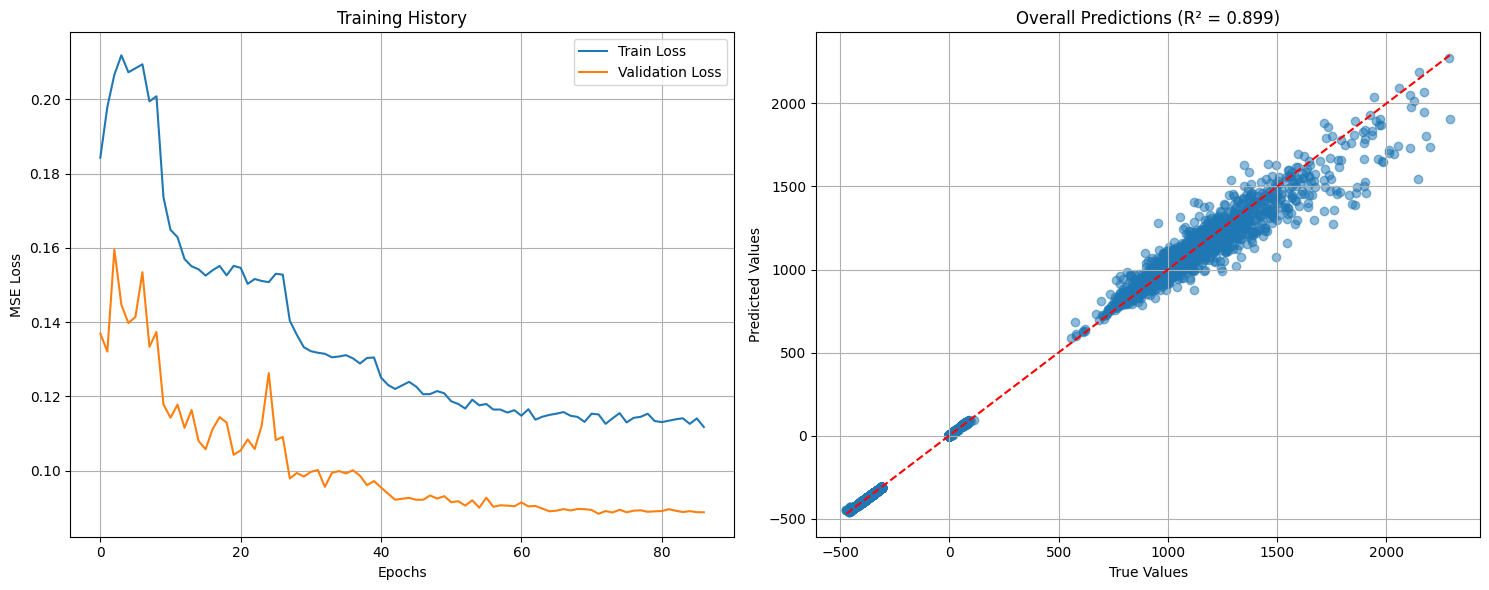

In [17]:
# ✅ IMPROVED: Better visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training history
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE Loss')
ax1.set_title('Training History')
ax1.legend()
ax1.grid(True)

# Prediction scatter plot (overall)
ax2.scatter(Y_test_df.values.flatten(), Y_pred_df.values.flatten(), alpha=0.5)
ax2.plot([Y_test_df.values.min(), Y_test_df.values.max()],
         [Y_test_df.values.min(), Y_test_df.values.max()], 'r--')
ax2.set_xlabel('True Values')
ax2.set_ylabel('Predicted Values')
ax2.set_title(f'Overall Predictions (R² = {overall_r2:.3f})')
ax2.grid(True)

plt.tight_layout()
plt.show()

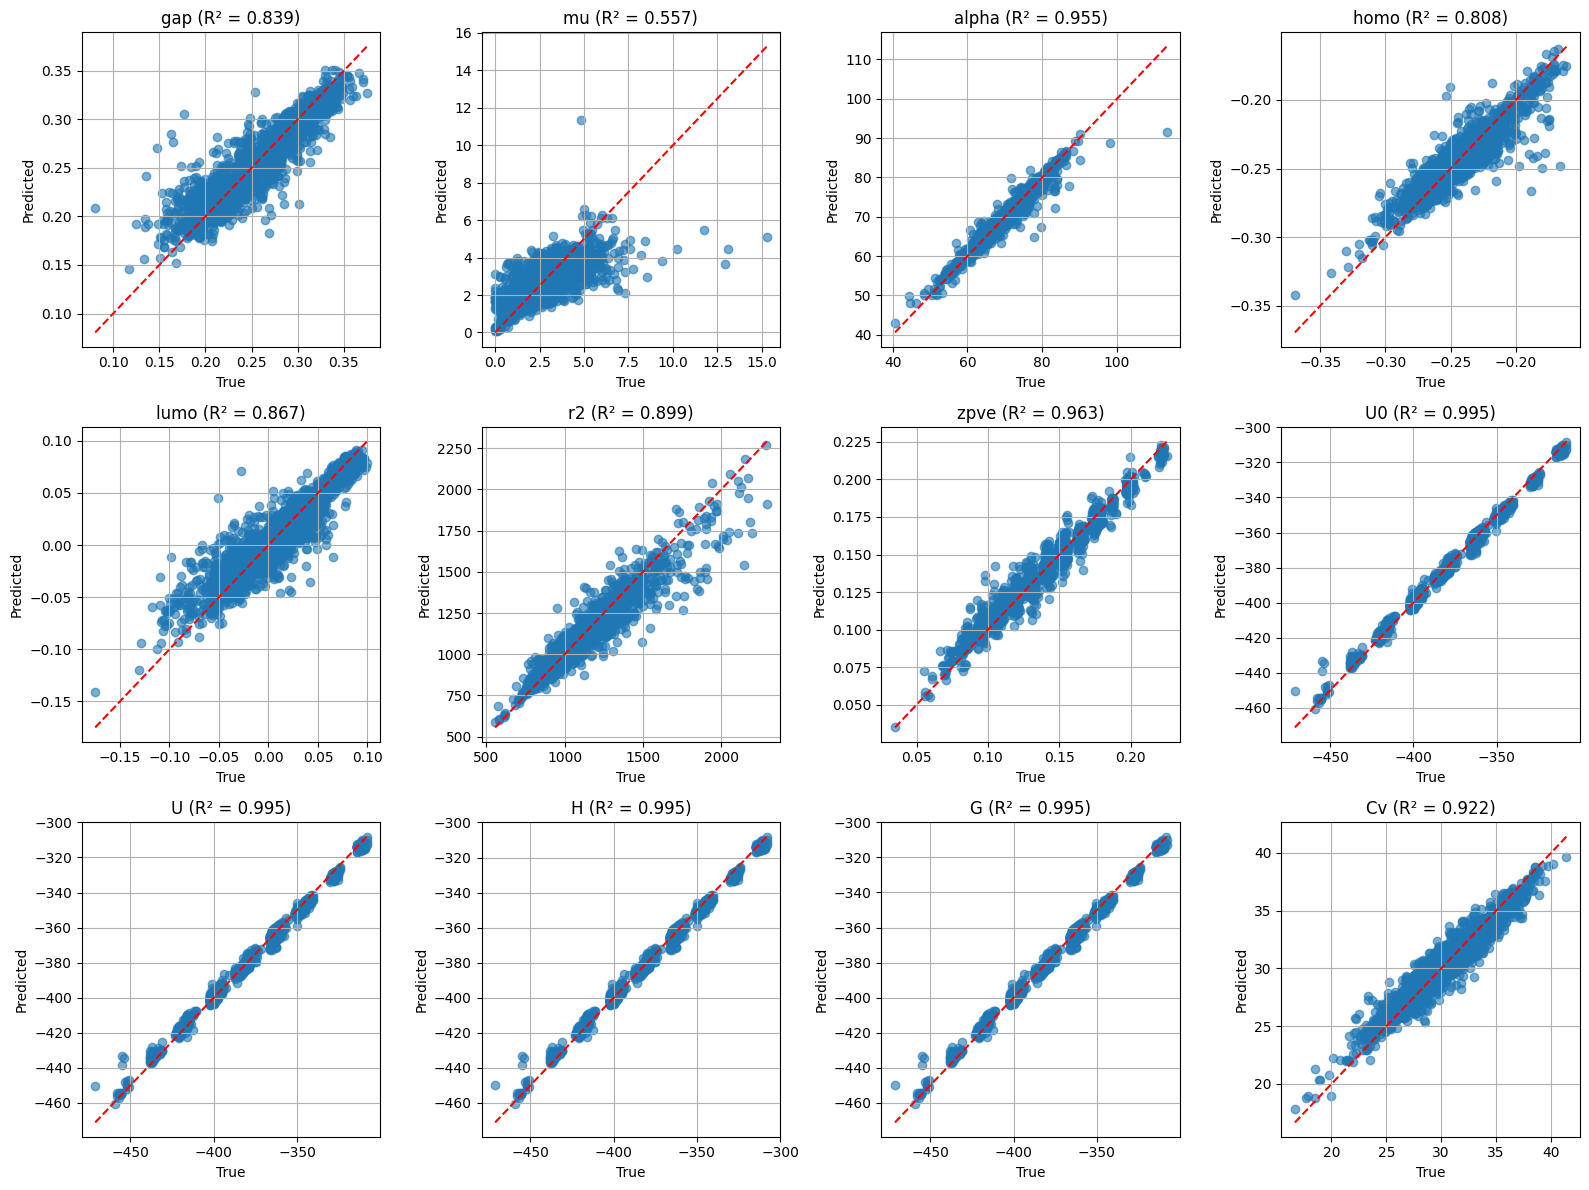

In [18]:
# Individual target plots
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i, target in enumerate(targets):
    ax = axes[i]
    ax.scatter(Y_test_df[target], Y_pred_df[target], alpha=0.6)
    ax.plot([Y_test_df[target].min(), Y_test_df[target].max()],
            [Y_test_df[target].min(), Y_test_df[target].max()], 'r--')
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    ax.set_title(f'{target} (R² = {results.loc[target, "R2"]:.3f})')
    ax.grid(True)

plt.tight_layout()
plt.show()